## Hashing

In [1]:
## Define some function useful for testing
import random

## generate an array of n random integers up to b
def get_random_array(n, b = 50):
    return [random.randint(0, b) for _ in range(n)]

---

### Open Addressing with linear probing

[Open addressing](https://en.wikipedia.org/wiki/Open_addressing) is a collision resolution technique used for handling collisions in hashing. 

All the items are stored in a table of size $\alpha n$, where $n$ is the number of keys and $\alpha > 1$ is the load factor.

Initially, the table contains only a special value ```None``` which says that the entry is empty. Another 
special value, say character ```'D'``` is used to mark a entry that contained a key that has been deleted.

A hash functon $h()$ is used to specify the order of entries to probe for a key to be inserted/searched/deleted. 
We start by probing $h(k)$ and, with linear probing, the sequence of probes $S(k)$ is $h(k), h(k)+1, h(k)+2, \ldots$ , modulo $\alpha n$.

- **Insert** adds the key in the first empty slot that we found with positions in $S(k)$.
- **Lookup** is performed by checking positions in $S(k)$ until we find either the key or ```None```.
- **Delete** is performed by first sesrching the key and then by replacing it with ```'D'```. Why don't we use ```None``` instead? 


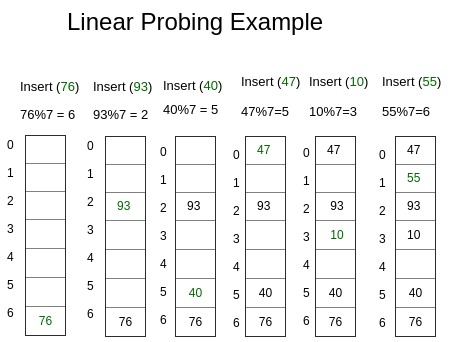

### Exercise: Open Addressing with linear probing
Complete the implementation below by implementing ```Lookup```and ```Delete```.


**Optional:** Try to implement quadratic probing. This is the technique employed by Python's set and dictionary. **Note:** not all the value of $c_1$ and $c_2$ are correct. If you generate them at random, for some of them you'll not be able to insert all the key and you'll get a random loop even if the code is correct. 

In [2]:
class linear_probing_set:
    def __init__(self, size):
        
        self.T = [None]*size
        self.prime = 993319
        self.a = random.randint(2, self.prime-1)
        self.b = random.randint(2, self.prime-1)
        self.n_keys = 0
    
    def insert(self, key): # fix len(T) < self.n_keys if you want
        if self.lookup(key):
            return
        h = self.hash(key)
        while self.T[h] != None and self.T[h] != 'D':
            h += 1
            if h == len(self.T):
                h = 0
        self.T[h] = key
        self.n_keys += 1
    
    # Return True if key is in the set, False otherwise
    def lookup(self, key, bool_out = True):
        i = 0 #to track the number of steps to find the key in presence of collisions
        h = self.hash(key)
        
        while self.T[h] != None and i != len(self.T): 
        #while it's not None it may be a collision
        # and if I didn't performed a full check of the Table I should continue

            if self.T[h] == key:
                if bool_out == True:
                    return True
                else:
                    return h
            i += 1
            h += 1
            if h == len(self.T):
                h = 0

        if bool_out == True:
            return False #so that I can compare with the "in" operator
        else:
            return None #so that delete works (otherwise with h = 0 I wouldn't be able to delete only with False)
    
    def delete(self, key):
        h = self.lookup(key, bool_out = False) #so that if True I get the position
        
        if h != None:
            self.T[h] = 'D'
            
        return
    
    def hash(self, key):
        return ((self.a*key + self.b) % self.prime) % len(self.T)
    
    def len(self):
        return self.n_keys

In [3]:
from tqdm import trange

for _ in trange(200):
    n = 10000

    a = get_random_array(n, n)

    queries = get_random_array(n, n)

    lp_set = linear_probing_set(2*n)
    std_set = set()

    for key in a:
        lp_set.insert(key)
        std_set.add(key)

    assert len(std_set) == lp_set.len(), "Fail len!"
        
    for key in a:
        assert lp_set.lookup(key) == True, "Lookup fail a"
      
    for key in queries:
        assert lp_set.lookup(key) == (key in std_set), "Lookup fail queries"
        
    for key in a[:300]:
        lp_set.delete(key)
        try:
            std_set.remove(key)
        except:
            pass # the key has been already removed
              
        assert lp_set.lookup(key) == (key in std_set), f"Lookup fail delete: {key}"


100%|██████████| 200/200 [00:18<00:00, 10.74it/s]


In [4]:
%timeit for key in queries: lp_set.lookup(key)

%timeit for key in queries: key in std_set
    
%timeit for key in queries: key in list(std_set)

9.43 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
809 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.67 s ± 46.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


----
### Hashing with Chains
Instead of just storing the elements in the slots in the table $T$, let every slot be a list which contains all the elements which are in the table and map to that slot. Our operations now become:

- `Insert` $(k)$: hash $k$ to an index $i$ in the table. You may want to check if $k$ is already in the set first.
- `Lookup` $(k)$: search for $k$ in the list by iterating through all the list.
- `Delete` $(k)$: search for $k$ and then remove it from the list.

Lookup and Delete takes $O(s)$ time where $s$ is the size of the list. We define $\alpha = \frac{n}{m}$ as the **load factor**. If we assume simple uniform hashing, then each element has equal probability to go into any slot. So after $n$ independent elements have been inserted we have and expected length of $\frac{n}{m} = \alpha$ for each chain by linearity of expectation. So the run time of all the above operations is time to hash + time to do these operations which is $O(1 + \alpha)$.

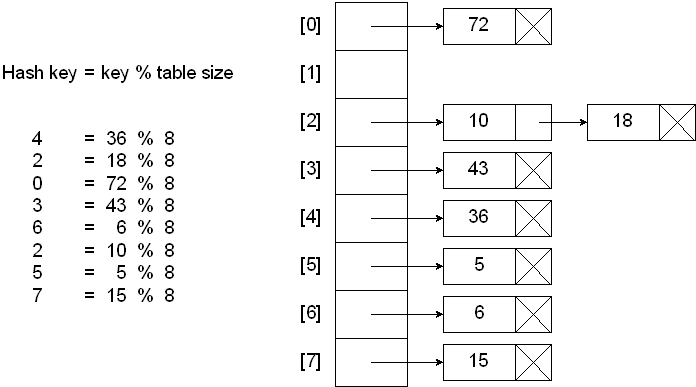

### Exercise: Hashing with Chains
Complete the implementation below by implementing ```Lookup``` and ```Delete```.

In [5]:
class chaining_set:
    def __init__(self, size):
        
        self.T = []
        for _ in range(size):
            self.T.append([])
        ## self.T = [ [] for _ in range(size)]
        ## why not self.T = [ [] ] * size ?
        
        self.prime = 993319
        self.a = random.randint(2, self.prime-1)
        self.b = random.randint(2, self.prime-1)
        self.n_keys = 0
        
    def insert(self, key):
        if self.lookup(key):
            return
        
        h = self.hash(key)
        self.T[h].append( key )
        self.n_keys += 1
    
    # return True if key is in the set, False otherwise
    def lookup(self, key, bool_out = True):
        h = self.hash(key)
        for n, el in enumerate(self.T[h]):
            if el == key:
                if bool_out == True: return True
                else: return n # I need it to pop the element in the delete func

        if bool_out == True: return False
        else: return None #to avoid problem with position 0
    
    def delete(self, key):
        h = self.hash(key)
        pos = self.lookup(key, bool_out = False)
        
        if pos != None:
            self.T[h].pop(pos)
        return
            
    def hash(self, key):
        return ((self.a*key + self.b) % self.prime) % len(self.T)
    
    def len(self):
        return self.n_keys

In [6]:
## Test your implementation

for _ in trange(200):
    n = 10000

    a = get_random_array(n, n)

    queries = get_random_array(n, n)

    c_set = chaining_set(2*n)
    std_set = set()

    for key in a:
        c_set.insert(key)
        std_set.add(key)

    assert len(std_set) == c_set.len(), "Fail len!"     
        
    for key in a:
        assert c_set.lookup(key) == True, "Lookup fail a"
      
    for key in queries:
        assert c_set.lookup(key) == (key in std_set), "Lookup fail queries"
        
    for key in a[:300]:
        c_set.delete(key)
        try:
            std_set.remove(key)
        except:
            pass # the key has been already removed
              
        assert c_set.lookup(key) == (key in std_set), "Lookup fail delete"  

100%|██████████| 200/200 [00:18<00:00, 10.76it/s]


In [7]:
%timeit for key in queries: c_set.lookup(key)
    
%timeit for key in queries: key in std_set

%timeit for key in queries: key in list(std_set)

12 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
791 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.64 s ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


----

### Exercise: Dictionary
Modify the previous code (i.e., Hashing with Chains) to implement a dictionary, i.e., store a value together with each key. 
You need to implement methods:
- ```Insert(key, value)```: insert the key with its value. If the key was already present, change its value;
- ```Delete(key)```: remove the key;
- ```Lookup(key)```: return True if the key is present, False otherwise;
- ```Value(key)```: return the value associated with the key. It returns None, if the key is not present.

I suggest to store pairs (key, value) within the lists.


**Optional**. 
Implement ```keys()```, ```values()```, and ```items()``` which allows you to iterate over keys, values, and pairs (key, value) respectively. You have to use ```yield``` to implement each generator.  

In [8]:
class try_dictionary:
    def __init__(self, size):
        
        self.T = []
        for _ in range(size):
            self.T.append([])
        ## self.T = [ [] for _ in range(size)]
        ## why not self.T = [ [] ] * size ?
        
        self.prime = 993319
        self.a = random.randint(2, self.prime-1)
        self.b = random.randint(2, self.prime-1)
        self.n_keys = 0
        
    def insert(self, key, value):
        h = self.hash(key)
        pos = self.lookup(key, bool_out = False)
        if pos != None:
            self.T[h][pos][1] = value
            return
        
        self.T[h].append( [key, value] )
        self.n_keys += 1
    
    # return True if key is in the set, False otherwise
    def lookup(self, key, bool_out = True):
        h = self.hash(key)
        for n, el in enumerate(self.T[h]):
            if el[0] == key:
                if bool_out == True: return True
                else: return n # I need it to pop the element in the delete func

        if bool_out == True: return False
        else: return None #to avoid problem with position 0
    
    def delete(self, key):
        h = self.hash(key)
        pos = self.lookup(key, bool_out = False)
        
        if pos != None:
            self.T[h].pop(pos)
        return

    def value(self, key):
        pos = self.lookup(key, bool_out = False)
        
        if pos != None:
            h = self.hash(key)
            return self.T[h][pos][1]

        return None
            
    def hash(self, key):
        return ((self.a*key + self.b) % self.prime) % len(self.T)
    
    def len(self):
        return self.n_keys

    def keys(self):
        for n in range(len(self.T)):
            if self.T[n] != []:
                for el in self.T[n]:
                    yield el[0]

    def values(self):
        for n in range(len(self.T)):
            if self.T[n] != []:
                for el in self.T[n]:
                    yield el[1]

    def items(self):
        for n in range(len(self.T)):
            if self.T[n] != []:
                for el in self.T[n]:
                    yield (el[0], el[1])

In [9]:
def test_dict():
    my_dict = try_dictionary(10)

    data = [(2, 'women'), (12, 'men'), (42, 'meanings'), 
            (1000, 'needles'), (59082, 'losses'), (1, 'victory'), 
            (33, 'years'), (350, 'saboteurs'), (500, 'magicians'), 
            (4, 'millenials'), (33, 'dragons')]  #I want to replace years with dragons

    for key, value in data:
        my_dict.insert(key, value)

    assert my_dict.lookup(350) == True, 'Key not found'
    assert my_dict.lookup(1000000000000) == False, 'Not present key found'
    assert my_dict.value(350) == 'saboteurs', 'Wrong value'
    assert my_dict.value(33) == 'dragons', 'Value not replaced correctly'

    assert my_dict.len() == len(data) -1, 'Length not corresponding'
    assert set(my_dict.keys()) == set(x[0] for x in data), 'Keys not corresponding'
    assert set(my_dict.values()) == set(x[1] for x in data if x[1] != 'years'), 'Values not corresponding'
    assert set(my_dict.items()) == set(x for x in data if x != (33, 'years')), 'Items not corresponding'

    my_dict.delete(1)
    assert set(my_dict.items()) == set(x for x in data if x != (33, 'years') and x != (1, 'victory')), 'Item not deleted correctly'

In [10]:
test_dict()